# Exercise 13 (3) - Hamiltonian & Lagrangian Neural Networks
### Task
Implement and train a conventional neural network for dynamics
- Implement the cost computation in the training loop
- Perform a training with the implemented neural network and compare it to the Hamiltonian neural network (`exercise13_1.ipynb`) and the Lagrangian neural network (`exercise13_2.ipynb`)

### Learning goals
- Familiarize yourself with Hamiltonian dynamics and neural networks

In [1]:
import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(2)

## User settings

**sampling parameters**

In [3]:
dx0dt = 1
k = 10
m = 1

tmaxTraining = 1.5 
numberOfTrainingSamples = 50
tmaxValidation = 9
numberOfValidationSamples = 300

**neural network architecture**

In [4]:
neurons = 50
layers = 2

**hyperparameters**

In [5]:
lr = 1e-3
epochs = 5000

## Utilities

**neural network**

In [6]:
class FNN(torch.nn.Module):
    def __init__(self, inputSize, outputSize, neurons, layers):
        super().__init__()

        self.layers = layers

        self.linear1 = torch.nn.Linear(inputSize, neurons)
        self.linear2 = torch.nn.ModuleList()
        for i in range(self.layers):
            self.linear2.append(torch.nn.Linear(neurons, neurons))
        self.linear3 = torch.nn.Linear(neurons, outputSize)
        self.activation = torch.nn.Tanh()

    def forward(self, x):
        y = self.activation(self.linear1(x))
        for i in range(self.layers):
            y = self.activation(self.linear2[i](y))
        y = self.linear3(y)
        return y

**derivative function**

In [7]:
def getDerivative(y, x, n):
    """Compute the nth order derivative of y = f(x) with respect to x."""

    if n == 0:
        return y
    else:
        dy_dx = grad(y, x, torch.ones_like(y), create_graph=True, retain_graph=True)[0]
        return getDerivative(dy_dx, x, n - 1)

## Data generation

**analytical solution**

In [8]:
omega = np.sqrt(k / m)

A = dx0dt / omega
phi = 0
x = lambda t: A * np.sin(omega * t + phi)
dxdt = lambda t: omega * A * np.cos(omega * t + phi)
ddxdtt = lambda t: - omega ** 2 * A * np.sin(omega * t + phi)

**training data**

In [9]:
tTraining = np.linspace(0, tmaxTraining, numberOfTrainingSamples)
trainingData = torch.vstack((torch.from_numpy(x(tTraining)),
                             m * torch.from_numpy(dxdt(tTraining)),
                             m * torch.from_numpy(ddxdtt(tTraining)))).to(torch.float32).T

**validation data**

In [10]:
tValidation = np.linspace(0, tmaxValidation, numberOfValidationSamples)
validationData = torch.vstack((torch.from_numpy(x(tValidation)),
                               m * torch.from_numpy(dxdt(tValidation)),
                               m * torch.from_numpy(ddxdtt(tValidation)))).to(torch.float32).T

**model input**

In [11]:
modelInputTraining = trainingData[:, :2]
modelInputTraining.requires_grad = True

modelInputValidation = validationData[:, :2]
modelInputValidation.requires_grad = True

## Supervised training

**pre-processing**

In [12]:
model = FNN(2, 2, neurons, layers)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
costHistory = np.zeros(epochs)

**training loop**

In [13]:
for epoch in range(epochs):
    optimizer.zero_grad()

    xPred = model(modelInputTraining)

    cost = torch.mean((xPred - trainingData[:, 1:]) ** 2)
    costHistory[epoch] = cost.detach()

    cost.backward()

    optimizer.step()

    if epoch % 50 == 0:
        print("Epoch: {}/{}\t\tCost function: {:.3E}".format(epoch, epochs, cost.detach()))

Epoch: 0/5000		Cost function: 2.999E+00
Epoch: 50/5000		Cost function: 7.894E-01
Epoch: 100/5000		Cost function: 1.921E-03
Epoch: 150/5000		Cost function: 4.565E-04
Epoch: 200/5000		Cost function: 3.131E-04
Epoch: 250/5000		Cost function: 2.380E-04
Epoch: 300/5000		Cost function: 1.925E-04
Epoch: 350/5000		Cost function: 1.616E-04
Epoch: 400/5000		Cost function: 1.381E-04
Epoch: 450/5000		Cost function: 1.189E-04
Epoch: 500/5000		Cost function: 1.028E-04
Epoch: 550/5000		Cost function: 8.899E-05
Epoch: 600/5000		Cost function: 7.704E-05
Epoch: 650/5000		Cost function: 6.667E-05
Epoch: 700/5000		Cost function: 5.765E-05
Epoch: 750/5000		Cost function: 4.979E-05
Epoch: 800/5000		Cost function: 4.296E-05
Epoch: 850/5000		Cost function: 3.705E-05
Epoch: 900/5000		Cost function: 3.194E-05
Epoch: 950/5000		Cost function: 2.755E-05
Epoch: 1000/5000		Cost function: 2.380E-05
Epoch: 1050/5000		Cost function: 2.059E-05
Epoch: 1100/5000		Cost function: 1.787E-05
Epoch: 1150/5000		Cost function: 1

## Post-processing

In [14]:
numberOfTimeSteps = 10000  # for the forward Euler scheme

**forward Euler scheme**

In [15]:
tPrediction = np.linspace(0, tmaxValidation, numberOfTimeSteps + 1)
dt = tmaxValidation / numberOfTimeSteps
xPrediction = torch.zeros((2, numberOfTimeSteps + 1), requires_grad=False)

xPrediction[:, 0] = validationData[0, :2]

for i in range(numberOfTimeSteps):
    xPrediction[:, i + 1] = (xPrediction[:, i] + dt * model(xPrediction[:, i])).detach()

**transient response**

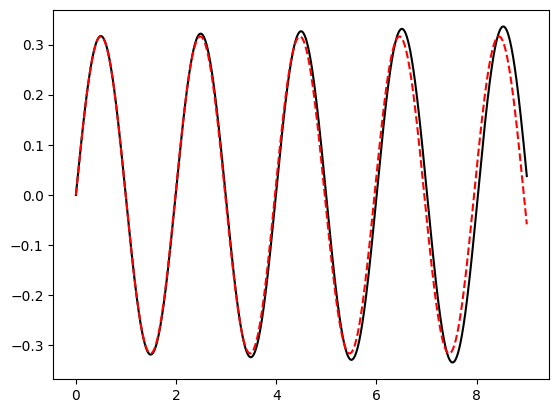

In [16]:
fig, ax = plt.subplots()
ax.plot(tPrediction, xPrediction[0, :], 'k')
ax.plot(tValidation, validationData[:, 0], 'r--')
plt.show()

**position-momentum space**

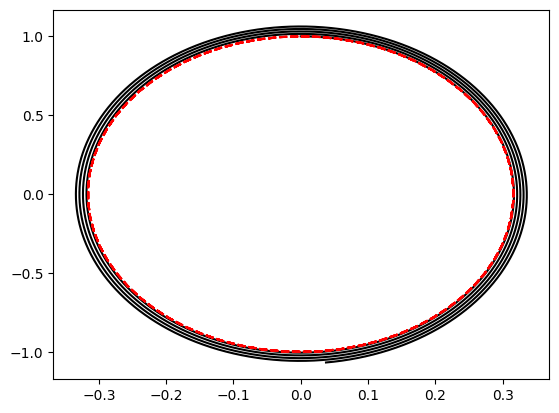

In [17]:
fig, ax = plt.subplots()
ax.plot(xPrediction[0, :], xPrediction[1, :], 'k')
ax.plot(validationData[:, 0], validationData[:, 1], 'r--')
plt.show()

**energy evolution**

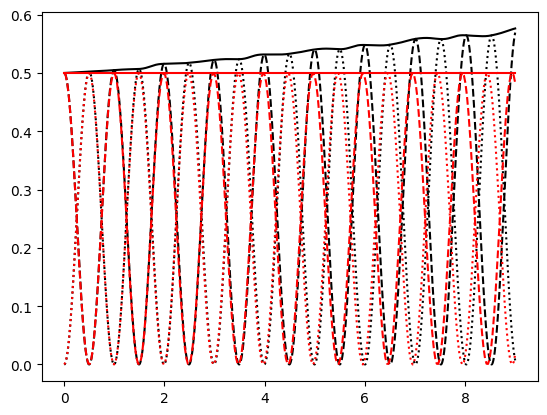

In [18]:
fig, ax = plt.subplots()
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2, 'k--')
ax.plot(tPrediction, 0.5 * k * xPrediction[0, :] ** 2, 'k:')
ax.plot(tPrediction, 0.5 / m * xPrediction[1, :] ** 2 + 0.5 * k * xPrediction[0, :] ** 2, 'k')

ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2, 'r--')
ax.plot(tValidation, 0.5 * k * validationData[:, 0] ** 2, 'r:')
ax.plot(tValidation, 0.5 / m * validationData[:, 1] ** 2 + 0.5 * k * validationData[:, 0] ** 2, 'r')
plt.show()

**learning history**

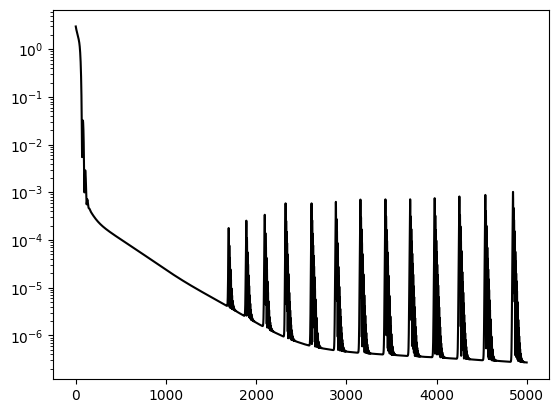

In [19]:
fig, ax = plt.subplots()
ax.plot(costHistory, 'k')
ax.set_yscale('log')
plt.show()

O exercício 13.3 propõe a implementação de uma rede neural convencional para modelar a dinâmica de sistemas físicos, especificamente um sistema massa-mola. Diferentemente das abordagens baseadas em formalismos físicos, como as redes neurais hamiltonianas (HNNs) e lagrangianas (LNNs), esta abordagem utiliza uma rede neural feedforward para aprender diretamente a aceleração a partir das variáveis de estado (posição e velocidade), sem incorporar explicitamente as leis de conservação da mecânica clássica.

A arquitetura da rede consiste em camadas densas com funções de ativação não lineares, recebendo como entrada os pares de posição e velocidade, e retornando a aceleração prevista. Durante o treinamento, a rede é ajustada para minimizar a diferença entre as acelerações previstas e os valores reais obtidos a partir da solução analítica do sistema massa-mola. Essa abordagem permite que a rede aprenda a dinâmica do sistema com base nos dados fornecidos, sem a necessidade de conhecimento prévio das equações de movimento.

Após o treinamento, a rede é utilizada para prever a evolução temporal do sistema utilizando métodos numéricos, como o esquema de Euler explícito. As previsões são então comparadas com as soluções analíticas para avaliar a precisão do modelo. Embora essa abordagem possa fornecer boas previsões em curto prazo, ela tende a acumular erros ao longo do tempo, especialmente em sistemas onde a conservação de energia é crucial, devido à ausência de restrições físicas explícitas no modelo.

Em comparação com as HNNs e LNNs, que incorporam diretamente as leis de conservação da mecânica clássica em sua estrutura, as redes neurais convencionais podem apresentar limitações em termos de estabilidade e generalização em longo prazo. No entanto, elas oferecem uma abordagem mais direta e flexível para modelar sistemas dinâmicos, sendo úteis em situações onde o conhecimento das equações de movimento é limitado ou os dados disponíveis são abundantes.